In [1]:
import numpy as np
from scipy import constants as const
from matplotlib import pyplot as plt
from numpy import fft

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

The linearity of the Maxwell equations means that any electromagnetic field - including electromagnetic waves - can be described as a superposition of electromagnetic fields. Consider an electromagnetic plainwave propagating in the z direction, $E(z, t)$. Thanks to the aforementioned superposition theorem, we can express this as a continuus superposition of monochromatic planewaves with appropriate amplitudes and phases, as described by the (inverse) Fourier transform:
$$
E(z, t) = \frac{1}{2\pi}\int_{-\infty}^{\infty}U(z, \omega) e^{\mathrm{i}\omega t} \mathrm{d}\omega
$$
where 
$$
U(z, \omega) = U_0(\omega)e^{-\mathrm{i} \phi(z, \omega)}.
$$
$U_0$ can also be found from the time-domain wave $E(z, t)$ using Fourier transform:
$$
U_0(\omega) = \int_{-\infty}^{\infty} E(z=0, t) e^{-\mathrm{i} \omega t} \mathrm{d}t
$$
Our interest is focused on the spectral phase, $\phi(z, \omega)$. During propagation in vacuum or in a nondispersive medium (with constant refractive index $n(\omega) = n_{mat}$), this phase will be at most linearly dependent on the frequency: 
$$
\phi(z, \omega) = kz = \frac{\omega n_{mat}}{c}z
$$
where $c$ is the speed of light in vacuum, and $k=\omega n_{mat}$. As such, it can at most introduce a temporal delay in $E(z, t)$ (corresponding to the refractive index and thus the reduced speed of light in the material), but does not have effect on the shape of the electromagnetic wave. However, if the pulse propagates through a dispersive material, $\phi(z, \omega)$ becomes nonlinearly dependent on the wavelength as defined by the dispersive refractive index $n(\omega)$:
$$
\phi(z, \omega) = k(\omega)z = \frac{\omega n(\omega)}{c}z.
$$
To adress these dispersive effects, we introduce the phase derivatives by taking the Taylor expansion of $\phi(z, \omega)$ around a defined central frequency $\omega_0$:
$$
\phi(z, \omega) = \sum_{m=0}^{\infty} \frac{\phi^{(m)}(z, \omega_0)}{m!} (\omega-\omega_0)^m = 
\phi_0 
+ \phi'_0 \left(\omega-\omega_0\right) 
+ \frac{\phi''_0}{2} \left(\omega-\omega_0\right)^2 
+ \frac{\phi'''_0}{6} \left(\omega-\omega_0\right)^3 
+ \frac{\phi''''_0}{24} \left(\omega-\omega_0\right)^4 
+ \dots
$$
where $\phi^{(m)} = \frac{\mathrm{d}^{m}\phi}{\mathrm{d}\omega^m}$ is the m-th derivative of $\phi(z, \omega)$ with respect to $\omega$, and $\phi^{(m)}_0 = \phi^{(m)}(z,\omega_0)$. The following quantities can be defined:
- $GD =\phi'_0$: Group Delay
- $GDD =\phi''_0$: Group Delay Dispersion
- $TOD =\phi'''_0$: Third Order \[phase\] Derivative
- $FOD =\phi''''_0$: Fourth Order \[phase\] Derivative
- and so on: while arbirtary high order derivatives can be defined, the above is ususally sufficient.

The effect of these derivatives can be investigated in detail. 
- **GD** introduces a *temporal delay*, but does not change the shape of the electromagnetic radiation iself;
- **GDD** causes a temporal broadening, and famously introduces a *chirp*, a (linear) change of the instantenous frequency in the time-domain;
- **TOD** introduces *trailing pulses* and may cause further temporal delay and broadening;
- **FOD** may cause *shoulders*, pre- and postpulses symmetrically surrounding the main pulse.

In the following, we investigate the effects of these phase derivatives on a laser pulse with  Gaussian temporal profile propagating in 1D along the z axis. Try different values, such as:
- $GD = 5 fs$
- $GDD = 50 fs^2$
- $TOD = 20 fs^3$
- $FOD = 100 fs^4$

In [58]:
# ~~ Parameters of the calculation ~~

C_LIGHT = const.speed_of_light * const.femto / const.micro      # speed of light in um/fs

A0 = 1                                      # amplitude (arb. uits)
lambda0 = 1.0                               # Central wavelength (um)
omega0 = 2*const.pi * C_LIGHT / lambda0     # central angular frequency (1/fs)
t_pulse = 5.0                               # Temporal FWHM length of the transform-limited pulse (fs)
GD  = 0                                     # Group delay (fs)
GDD = 50                                    # GDD (fs^2)
TOD = 0                                     # TOD (fs^3)
FOD = 0                                     # FOD (fs^4)

framenum = 3000                             # number of temporal (and spectral) samples
znum = 1000                                 # number of spatial samples

zmin, zmax = -60*lambda0, 60*lambda0        # spatial bounds in um
tmin, tmax = -500, 500                      # temporal bounds in fs

# spatial sample points
# t_points, dt = np.linspace(tmin, tmax, framenum, endpoint=True, retstep=True)
z_points, dz = np.linspace(zmin, zmax, znum, endpoint=True, retstep=True)

We choose a Gaussian spectral envelope:
$$
U_0(\omega) = A_0 \frac{\pi \tau}{2\sqrt{\mathrm{ln}2}} e^{-\frac{\tau^2}{4\mathrm{ln}2}\left(\omega-\omega_0\right)^2}
$$
and then proceed to calculate the $U(z, w)$ spectral components. After this, we get $E(z, t)$ via inverse FFT at each $z$ sample point.

In [59]:
def spectral_envelope(omega, t_p):
    "U_0 (w)"
    tau = t_p/2
    norm_factor = A0 * const.pi * tau / 2 * np.sqrt(np.log(2))
    exponent = -1 * tau**2 * (omega - omega0)**2 / (4 * np.log(2))
    # exponent = -1 * t_pulse**2 * (omega - omega0)**2 / (4 * np.log(2)**2)
    return norm_factor * np.exp(exponent)

def phase(z, omega):
    "phi(w, z)" 
    dom = omega - omega0
    ph = omega*z/C_LIGHT + GD*dom + GDD*dom**2/2 + TOD*dom**3/6 + FOD*dom**4/24
    return ph

def spectra(z, omega):
    "U(z, w)"
    envl = spectral_envelope(omega, t_pulse)
    phi = phase(z, omega)
    return envl * np.exp(-1j * phi)

def el_wave(z):
    "E(z, t)"
    dw = 2*np.pi/(tmax - tmin)
    w = np.arange(framenum) * dw
    dt = 2*np.pi/(w[-1])
    t = np.arange(framenum) * dt + tmin
    e_w = spectra(z, w)
    e_w *= np.exp(1j * w * tmin)
    e_t = fft.ifft(e_w)
    return t, e_t, (e_w, w)

def find_fwhm_width(x, y):
    "Find the x-width of the region where y > (max(y) / 2)"
    imax = np.argmax(y)
    thr = y[imax] / 2
    l = len(y)
    ilow = 0 if imax == 0 else np.searchsorted(y[:imax], thr)
    ihigh = l-1 if imax == l else l - np.searchsorted(y[imax:][::-1], thr)
    if ihigh == l:
        ihigh = l-1
    fwhm = x[ihigh] - x[ilow]
    return fwhm

In [60]:
# Calculate E(z, t) at each z-point
E = np.empty((znum, framenum), dtype=complex)
for i, z in enumerate(z_points):
    t, et, (E_omega, omegas) = el_wave(z)
    E[i] = et 
E = np.transpose(E)


Time to plot te results:

FWHM (at z=0.0, including secondary pulses):
55.6852 fs
(transform-limited: 5.0000 fs)


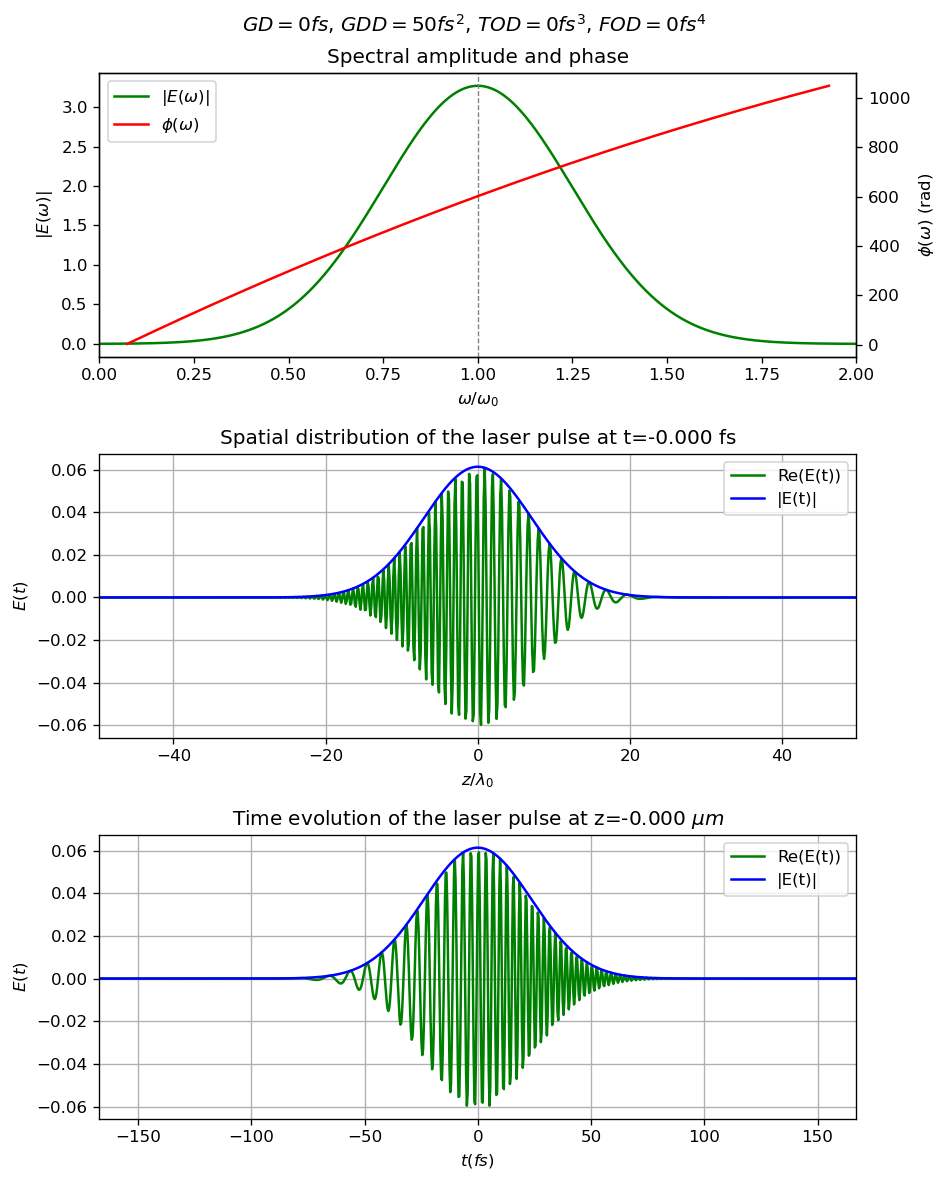

In [61]:
# the z and the t value where the temporal and the spatial evolution is plotted
tplot = -0.
zplot = 0.

# corresponding indices
i_tplot = (np.abs(t-tplot)).argmin()
i_zplot = (np.abs(z_points-zplot)).argmin()

# plot the spectrumm and the temporal and the spatial evolution at the selected locations
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,10))
p1, = ax1.plot(omegas/omega0, np.abs(E_omega), color='green', label="$|E(\omega)|$")
ax1.axvline(1, linewidth=0.8, linestyle='--', color='gray')
ax1.set_xlim(0, 2)
ax1.set_xlabel("$\omega / \omega_0$")
ax1.set_ylabel("$|E(\omega)|$")
phwhere = np.abs(E_omega) > np.amax(np.abs(E_omega)) * 1e-3
axph = ax1.twinx()
p2, = axph.plot(omegas[phwhere]/omega0, np.unwrap(np.angle(E_omega[phwhere]), np.pi), color='red', label="$\phi(\omega)$")
axph.legend(handles=(p1, p2))
axph.set_ylabel("$\phi (\omega)$ (rad)")

fwhm_z = find_fwhm_width(z_points, np.abs(E[i_tplot]))
ax2.plot(z_points/lambda0, E[i_tplot].real, 'g-', label='Re(E(t))')
ax2.plot(z_points/lambda0, np.abs(E[i_tplot]), 'b-', label='|E(t)|')
ax2.set_xlim(-3*fwhm_z, 3*fwhm_z)
ax2.grid()
ax2.set_xlabel("$z / \lambda_0$")
ax2.set_ylabel("$E(t)$")
ax2.legend()

fwhm = find_fwhm_width(t, np.abs(E[:,i_zplot]))
ax3.plot(t, E[:,i_zplot].real, 'g-', label='Re(E(t))')
ax3.plot(t, np.abs(E[:,i_zplot]), 'b-', label='|E(t)|')
ax3.set_xlim(-3*fwhm, 3*fwhm)
ax3.grid()
ax3.set_xlabel("$t (fs)$")
ax3.set_ylabel("$E(t)$")
ax3.legend()

ax1.set_title("Spectral amplitude and phase")
ax2.set_title(f"Spatial distribution of the laser pulse at t={tplot:.3f} fs")
ax3.set_title(f"Time evolution of the laser pulse at z={tplot:.3f} $\mu m$")

fig.suptitle(f"$GD={GD:.0f}fs$, $GDD={GDD:.0f}fs^2$, $TOD={TOD:.0f}fs^3$, $FOD={FOD:.0f}fs^4$")

plt.tight_layout()
print(f"FWHM (at z={zplot:.2}, including secondary pulses):\n{fwhm:.4f} fs\n(transform-limited: {t_pulse:.4f} fs)")